# Beijing Air Quality Forecasting Starter Notebook


This notebook predicts PM2.5 levels in Beijing using an LSTM model.
####  The approach includes:
 1. Thorough data exploration (summary statistics, multiple visualizations)
 2. Preprocessing: handling missing values, datetime conversion, and data reshaping.
 3. Model building with an LSTM architecture.
 4. Training, evaluation, and additional model performance analyses.
 5. Generating a diagram of the model design and preparing final predictions for Kaggle submission.

 The overall strategy is to capture temporal dependencies in the data using RNNs (LSTMs),
 which are well-suited for time series data. The goal is to minimize the RMSE by testing
 various architectures and hyperparameters through systematic experimentation.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM,GRU, Dense, Dropout, Bidirectional, Conv1D, MaxPooling1D, Attention, BatchNormalization, Concatenate, Input, TimeDistributed, Add
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adagrad
from tensorflow.keras.utils import plot_model  # For model diagram
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import tensorflow as tf

In [2]:
# Load the datasets
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')


# Explore the training data

In this sections we are going to explore dataset with appropiate statistics and visualisations to understand the  dataset better.

In [3]:
# Inspecting the first few rows of the dataset to understand its structure.
print("Training Data Overview:")
train.head()

Training Data Overview:


,No,DEWP,TEMP,PRES,Iws,Is,Ir,datetime,cbwd_NW,cbwd_SE,cbwd_cv,pm2.5
0,1,-1.580878,-1.922250,0.443328,-0.441894,-0.069353,-0.137667,2010-01-01 00:00:00,1.448138,-0.732019,-0.522096,NaN
1,2,-1.580878,-2.004228,0.345943,-0.379306,-0.069353,-0.137667,2010-01-01 01:00:00,1.448138,-0.732019,-0.522096,NaN
2,3,-1.580878,-1.922250,0.248559,-0.343514,-0.069353,-0.137667,2010-01-01 02:00:00,1.448138,-0.732019,-0.522096,NaN
3,4,-1.580878,-2.168183,0.248559,-0.280926,-0.069353,-0.137667,2010-01-01 03:00:00,1.448138,-0.732019,-0.522096,NaN
4,5,-1.511594,-2.004228,0.151174,-0.218339,-0.069353,-0.137667,2010-01-01 04:00:00,1.448138,-0.732019,-0.522096,NaN


In [8]:
train.columns

Index(['No', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'datetime', 'cbwd_NW',
       'cbwd_SE', 'cbwd_cv', 'pm2.5'],
      dtype='object')

In [5]:
# Data types and missing values

print("\nData Types:")
print(train.dtypes)
print("\nMissing Values per Column:")
print(train.isnull().sum())


Data Types:
No            int64
DEWP        float64
TEMP        float64
PRES        float64
Iws         float64
Is          float64
Ir          float64
datetime     object
cbwd_NW     float64
cbwd_SE     float64
cbwd_cv     float64
pm2.5       float64
dtype: object

Missing Values per Column:
No             0
DEWP           0
TEMP           0
PRES           0
Iws            0
Is             0
Ir             0
datetime       0
cbwd_NW        0
cbwd_SE        0
cbwd_cv        0
pm2.5       1921
dtype: int64


In [4]:
# Summary Statistics (detailed)
print("\nSummary Statistics for Training Data:")
print(train.describe(include='all'))


Summary Statistics for Training Data:
                  No          DEWP          TEMP          PRES           Iws  \
count   30676.000000  30676.000000  30676.000000  30676.000000  30676.000000   
unique           NaN           NaN           NaN           NaN           NaN   
top              NaN           NaN           NaN           NaN           NaN   
freq             NaN           NaN           NaN           NaN           NaN   
mean    15338.500000     -0.029431     -0.062712      0.013612      0.030542   
std      8855.542765      0.994087      1.015193      1.008991      1.018337   
min         1.000000     -2.135153     -2.578070     -2.380821     -0.468688   
25%      7669.750000     -0.888034     -0.938521     -0.822670     -0.441894   
50%     15338.500000     -0.056622      0.045209     -0.043595     -0.352512   
75%     23007.250000      0.913358      0.864984      0.832865      0.005216   
max     30676.000000      1.814055      2.340578      2.877939     11.231956   



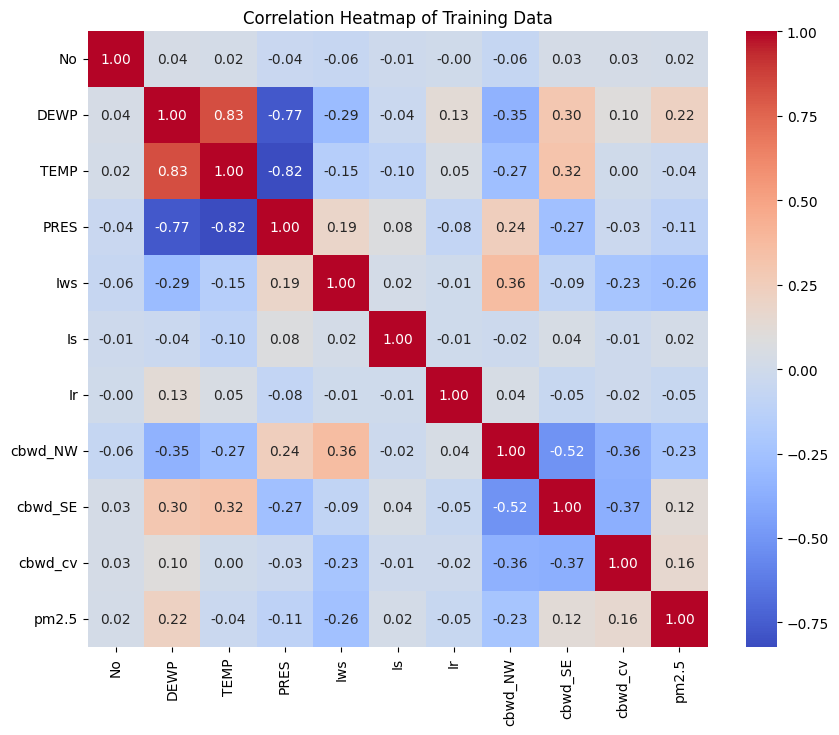

The correlation heatmap helps identify which features are strongly correlated with PM2.5 and with each other.


In [8]:
# Correlation heatmap to see the relationships between numeric features

plt.figure(figsize=(10, 8))
numeric_train = train.select_dtypes(include=['number'])
correlation_matrix = numeric_train.corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap of Training Data')
plt.show()
print("The correlation heatmap helps identify which features are strongly correlated with PM2.5 and with each other.")

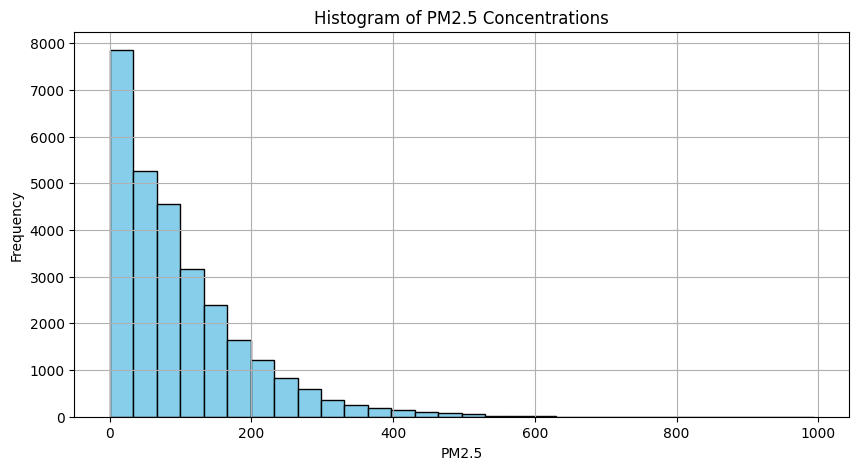

The histogram of PM2.5 concentrations shows its distribution, helping to identify skewness and potential outliers.


In [11]:
# Histogram for PM2.5 (target)

plt.figure(figsize=(10, 5))
plt.hist(train['pm2.5'], bins=30, color='skyblue', edgecolor='black')
plt.title('Histogram of PM2.5 Concentrations')
plt.xlabel('PM2.5')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()
print("The histogram of PM2.5 concentrations shows its distribution, helping to identify skewness and potential outliers.")

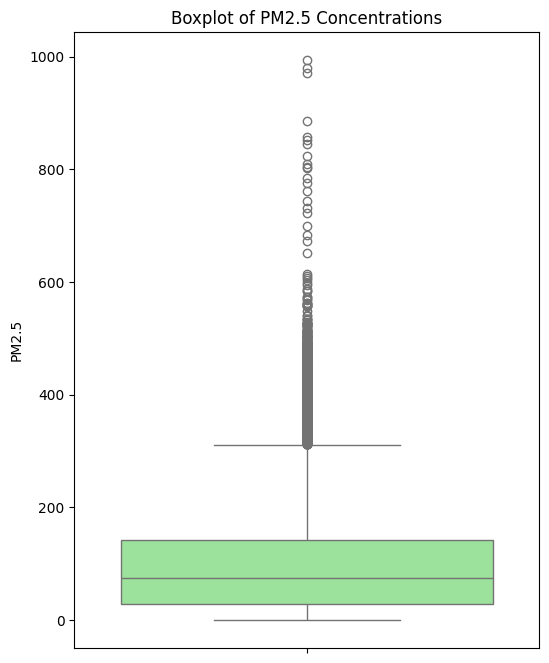

The boxplot of PM2.5 clearly shows the presence of outliers in the data.


In [10]:
# Boxplot for PM2.5 to visualize outliers

plt.figure(figsize=(6, 8))
sns.boxplot(y=train['pm2.5'], color='lightgreen')
plt.title('Boxplot of PM2.5 Concentrations')
plt.ylabel('PM2.5')
plt.show()
print("The boxplot of PM2.5 clearly shows the presence of outliers in the data.")

In [3]:
# Ensure 'datetime' column is in datetime format
train['datetime'] = pd.to_datetime(train['datetime'])

test['datetime'] = pd.to_datetime(test['datetime'])

# Set the 'datetime' column as the index for better time-series handling
train.set_index('datetime', inplace=True)
# val.set_index('datetime', inplace=True)
test.set_index('datetime', inplace=True)


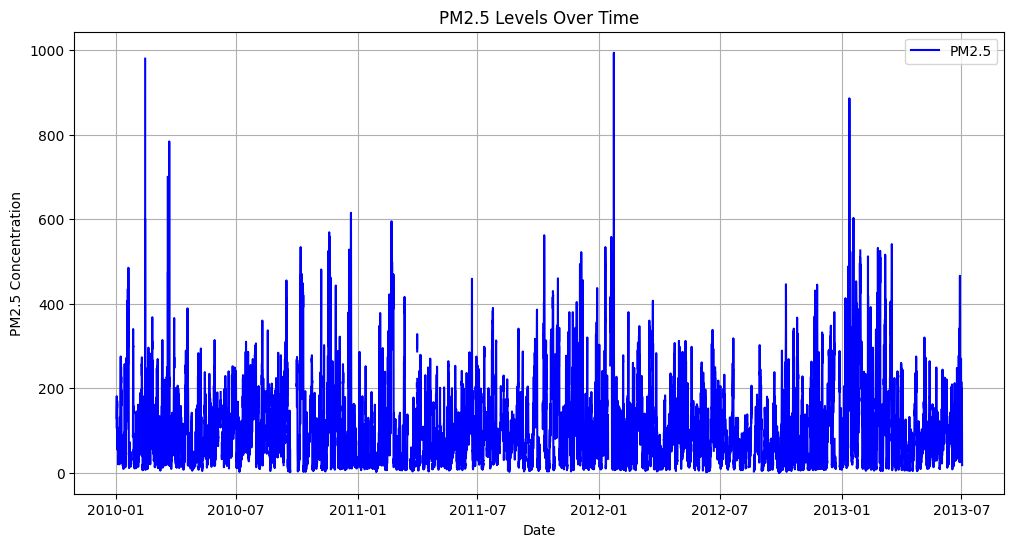

The time series plot illustrates trends and seasonal patterns in PM2.5 levels over time.


In [13]:
# Time Series Plot of PM2.5

plt.figure(figsize=(12, 6))
plt.plot(train.index, train['pm2.5'], color='blue', label='PM2.5')
plt.title('PM2.5 Levels Over Time')
plt.xlabel('Date')
plt.ylabel('PM2.5 Concentration')
plt.legend()
plt.grid(True)
plt.show()
print("The time series plot illustrates trends and seasonal patterns in PM2.5 levels over time.")

# Handle missing values


- Check the dataset for missing values and decide how to handle them.
- In this example, missing values are filled with the mean. You can experiment with other strategies.

In [4]:
train.fillna(train.mean(), inplace=True)
test.fillna(test.mean(), inplace=True)


# Separate features and target

- Feel free to trop any non-essential columns like that you think might not contribute to modeling.

In [11]:
print(train.columns)


Index(['No', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'cbwd_NW', 'cbwd_SE',
       'cbwd_cv', 'pm2.5'],
      dtype='object')


In [5]:
X_train = train.drop(['pm2.5', 'No'], axis=1)
y_train = train['pm2.5']

In [6]:
# Reshape data for LSTM input
# LSTM models require data in the shape (samples, timesteps, features).
# Here, the data is reshaped to add a "timesteps" dimension.
X_train = np.expand_dims(X_train, axis=1)

# Build model

## Model Design & Architecture:
### The chosen architecture includes:
 - Three stacked LSTM layers with decreasing unit sizes (128 → 64 → 32) to extract temporal dependencies.
 - Dropout and recurrent dropout for regularization to prevent overfitting.
 - Batch normalization after each LSTM layer to stabilize activations and improve convergence.
 - A Dense layer with ReLU activation before the final output layer to learn complex patterns.
 - A single neuron output layer for regression predictions (no activation function for raw values).
#
## The diagram below outlines the architecture:
#
            Input (timesteps, features)
                      │
      LSTM (128, tanh, return_sequences=True, dropout=0.2)
                      │
         BatchNormalization (normalizes activations)
                      │
      LSTM (64, tanh, return_sequences=True, dropout=0.2)
                      │
         BatchNormalization
                      │
      LSTM (32, tanh, return_sequences=False, dropout=0.2)
                      │
         BatchNormalization
                      │
           Dense (16, relu)
                      │
           Dropout (0.2)
                      │
           Dense (1)  →  Final Output

#

In [7]:
# Define the model
model = Sequential([
    # First LSTM layer with dropout
    LSTM(128, 
         activation='tanh',  # Default activation for LSTM; often works better than 'relu'
         return_sequences=True, 
         dropout=0.2, 
         recurrent_dropout=0.2, 
         input_shape=(X_train.shape[1], X_train.shape[2])),
    BatchNormalization(),  # Normalize activations for stability
    
    # Second LSTM layer
    LSTM(64, 
         activation='tanh', 
         return_sequences=True, 
         dropout=0.2, 
         recurrent_dropout=0.2),
    BatchNormalization(),
    
    # Third LSTM layer (no need for return_sequences if it's the last LSTM)
    LSTM(32, 
         activation='tanh', 
         dropout=0.2, 
         recurrent_dropout=0.2),
    BatchNormalization(),
    
    # Additional dense layer for learning complex patterns
    Dense(16, activation='relu'),
    Dropout(0.2),
    
    # Final output layer
    Dense(1)
])

# Define the optimizer with a possibly lower learning rate for more stable training
optimizer = Adam(learning_rate=0.0005)

# Compile the model using the built-in RootMeanSquaredError metric for clarity
model.compile(
    optimizer=optimizer,
    loss='mse',
    metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')]
)


# Display the model architecture
model.summary()



c:\Users\ElvisGuy\.conda\envs\primary\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1, 128)         │        70,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 1, 64)          │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1, 64)          │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 133,921 (523.13 KB)

 Trainable params: 133,473 (521.38 KB)

 Non-trainable params: 448 (1.75 KB)

In [10]:
# Train the model

callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)
]

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=64,
    callbacks=callbacks
)


Epoch 1/20
384/384 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 15737.4316 - rmse: 125.4277

384/384 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - loss: 15735.1260 - rmse: 125.4184 - val_loss: 18123.8066 - val_rmse: 134.6247 - learning_rate: 5.0000e-04
Epoch 2/20
378/384 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 9885.5684 - rmse: 99.3422

384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 9864.1172 - rmse: 99.2324 - val_loss: 9846.9736 - val_rmse: 99.2319 - learning_rate: 5.0000e-04
Epoch 3/20
381/384 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6818.2456 - rmse: 82.5609

384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 6814.8569 - rmse: 82.5403 - val_loss: 7843.3853 - val_rmse: 88.5629 - learning_rate: 5.0000e-04
Epoch 4/20
377/384 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6688.6787 - rmse: 81.6539

384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 6679.1587 - rmse: 81.5974 - val_loss: 7546.8032 - val_rmse: 86.8723 - learning_rate: 5.0000e-04
Epoch 5/20
381/384 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6400.6021 - rmse: 79.9845

384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 6398.4043 - rmse: 79.9709 - val_loss: 7495.6831 - val_rmse: 86.5776 - learning_rate: 5.0000e-04
Epoch 6/20
378/384 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5983.8599 - rmse: 77.3464

384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 5984.8022 - rmse: 77.3527 - val_loss: 7267.8579 - val_rmse: 85.2517 - learning_rate: 5.0000e-04
Epoch 7/20
380/384 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5788.1079 - rmse: 76.0650

384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 5791.0996 - rmse: 76.0847 - val_loss: 7177.7388 - val_rmse: 84.7215 - learning_rate: 5.0000e-04
Epoch 8/20
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 5922.5117 - rmse: 76.9315 - val_loss: 7379.4771 - val_rmse: 85.9039 - learning_rate: 5.0000e-04
Epoch 9/20
382/384 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5992.8677 - rmse: 77.4078

384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 5992.3247 - rmse: 77.4044 - val_loss: 7034.5571 - val_rmse: 83.8723 - learning_rate: 5.0000e-04
Epoch 10/20
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 6054.5864 - rmse: 77.8022 - val_loss: 7126.2583 - val_rmse: 84.4172 - learning_rate: 5.0000e-04
Epoch 11/20
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 5905.6440 - rmse: 76.8342 - val_loss: 7246.3389 - val_rmse: 85.1254 - learning_rate: 5.0000e-04
Epoch 12/20
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 5575.1348 - rmse: 74.6619 - val_loss: 7146.8696 - val_rmse: 84.5392 - learning_rate: 2.5000e-04


959/959 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step


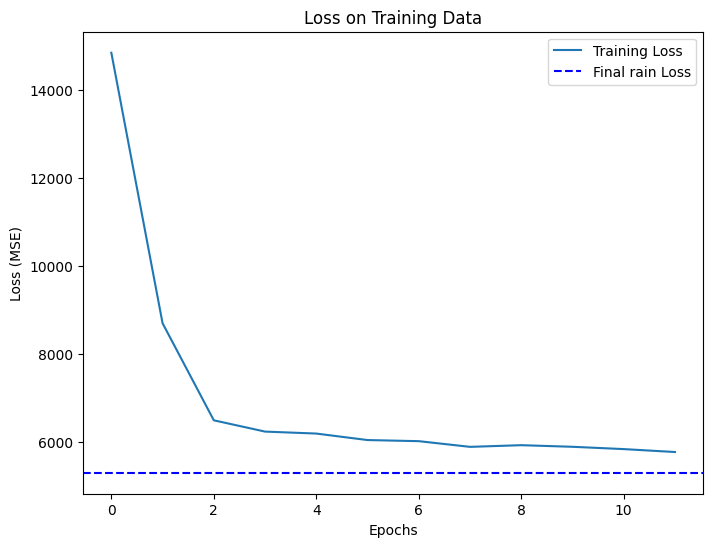

Final Training Loss (MSE): 5296.359811873128
Final RMSE on Training Data: 72.77609368379927


In [11]:
# Calculate training loss
train_predictions = model.predict(X_train)
train_loss = np.mean((y_train - train_predictions.flatten())**2)

# Plot training loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')  # Training loss during epochs
plt.axhline(y=train_loss, color='blue', linestyle='--', label='Final rain Loss')  # Final training loss
plt.title('Loss on Training Data')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

print(f"Final Training Loss (MSE): {train_loss}")
print(f"Final RMSE on Training Data: {np.sqrt(train_loss)}")

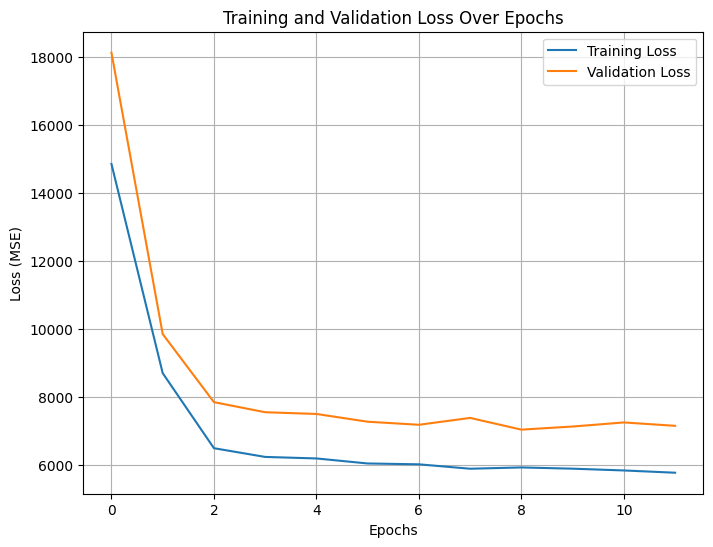

The loss curves help assess model convergence and potential overfitting.


In [12]:
# Plot training and validation loss curves.
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()
print("The loss curves help assess model convergence and potential overfitting.")


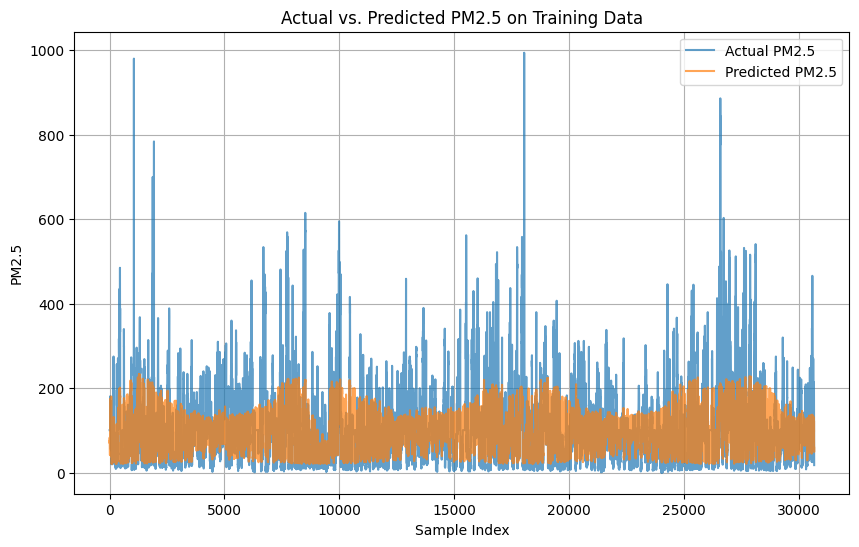

This plot of Actual vs. Predicted PM2.5 shows how closely the model fits the training data.


In [13]:
# Plot predictions vs. actual values on training data.
plt.figure(figsize=(10, 6))
plt.plot(y_train.values, label='Actual PM2.5', alpha=0.7)
plt.plot(train_predictions.flatten(), label='Predicted PM2.5', alpha=0.7)
plt.title('Actual vs. Predicted PM2.5 on Training Data')
plt.xlabel('Sample Index')
plt.ylabel('PM2.5')
plt.legend()
plt.grid(True)
plt.show()
print("This plot of Actual vs. Predicted PM2.5 shows how closely the model fits the training data.")


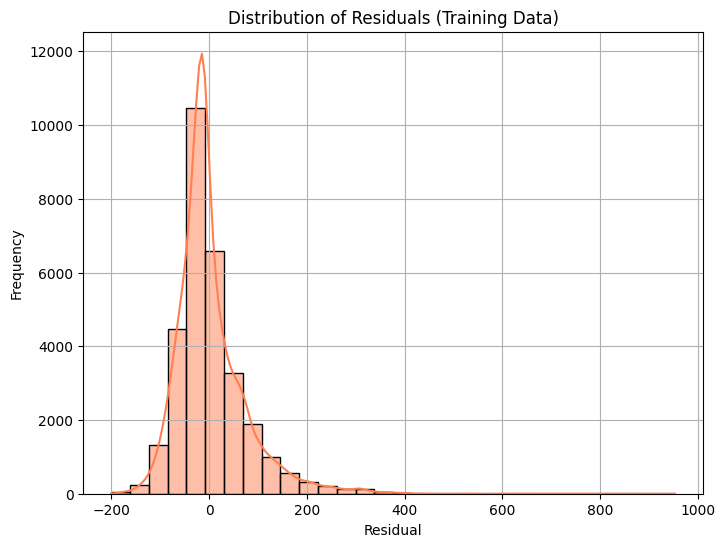

The residual plot provides insight into the error distribution, indicating model performance.


In [14]:
# Residual Plot: Error distribution for training predictions.
residuals = y_train - train_predictions.flatten()
plt.figure(figsize=(8, 6))
sns.histplot(residuals, bins=30, kde=True, color='coral')
plt.title('Distribution of Residuals (Training Data)')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()
print("The residual plot provides insight into the error distribution, indicating model performance.")

In [51]:
## Prepare the test data
X_test = test.drop(['No'], axis=1)
X_test = np.expand_dims(X_test, axis=1)

# Make predictions on the test set using trained model to predict "pm2.5" concentrations
predictions = model.predict(X_test)

# Ensure predictions do not contain NaN values
predictions = np.nan_to_num(predictions)

# Convert predictions to integers
predictions = np.round(predictions).astype(int)

# Prepare the submission file
# Convert 'row ID' index to string and remove leading zeros for single-digit hours
submission = pd.DataFrame({
    'row ID': pd.to_datetime(test.index).strftime('%Y-%m-%d %H:%M:%S').str.replace(r'(?<=\s)0(\d):', r'\1:', regex=True),  # Remove leading zeros for hours
    'pm2.5': predictions.flatten()
})

# Sort the submission by 'row ID' to match the solution file exactly
submission = submission.sort_values(by='row ID')

# Save the file in CSV format for submission on Kaggle
submission.to_csv('../submissions/submission16.csv', index=False)

411/411 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
